In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
url = "features_3_sec.csv"  # Replace with the actual URL or file path in Colab
data = pd.read_csv(url)

# Display the first few rows of the dataset
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.05033540725708,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.8376989364624023,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.9384244680404663,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.5803520679473877,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489194869995,26.738789,0.536961,29.146694,blues


In [ ]:
# Assuming your MFCC features are named 'mfcc1_mean', 'mfcc2_mean', ..., 'mfcc20_mean'
mfcc_features = [f'mfcc{i}_mean' for i in range(1, 21)]

# Select only the desired MFCC features and ensure they are numeric
X = data[mfcc_features].apply(pd.to_numeric, errors='coerce')

# Before dropping NA, keep track of the original index
original_index = X.index

# Drop rows with NA values
X = X.dropna()

# Get the new index after dropping NA
new_index = X.index

# Select the corresponding labels based on the new index
y = data.loc[new_index, 'label'].values # Assuming the last column is named 'label'


# Encode the labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.values.astype(np.float32), y_encoded, test_size=0.2, random_state=42)

# Reshape features for CNN input (if needed, e.g., for MFCCs)
X_train = X_train.reshape(X_train.shape[0], 20, 1, 1)  # Adjust dimensions as needed
X_test = X_test.reshape(X_test.shape[0], 20, 1, 1)

# Normalize feature values
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)

In [ ]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 1), activation='relu', input_shape=(20, 1, 1)),
    MaxPooling2D(pool_size=(2, 1)),  # Changed pool_size to (2, 1)
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y)), activation='softmax')  # Number of genres
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Set the learning rate here
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)                   │ (None, 18, 1, 32)           │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 9, 1, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 9, 1, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,410 (150.04 KB)

 Trainable params: 38,410 (150.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3031 - loss: 2.1060 - val_accuracy: 0.3985 - val_loss: 1.6236
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4061 - loss: 1.6527 - val_accuracy: 0.4799 - val_loss: 1.4947
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4432 - loss: 1.5686 - val_accuracy: 0.4776 - val_loss: 1.4518
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4712 - loss: 1.4811 - val_accuracy: 0.4968 - val_loss: 1.3791
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4852 - loss: 1.4532 - val_accuracy: 0.5261 - val_loss: 1.3388
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4905 - loss: 1.4396 - val_accuracy: 0.5361 - val_loss: 1.3269
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4932 - loss: 1.4155 - val_accuracy: 0.5388 - val_loss: 1.2930
Epoch 8/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5059 - loss: 1.3882 - val_accu

In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 73.49%


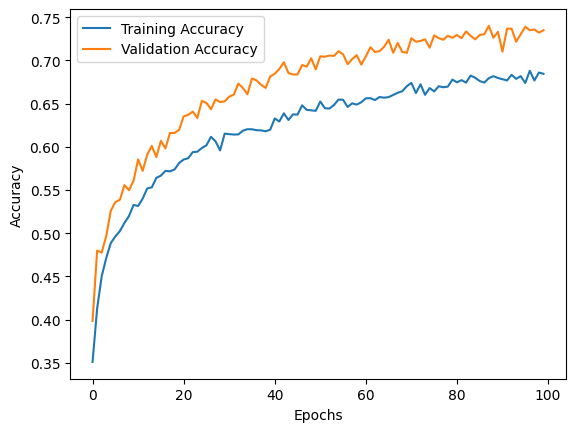

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Predict for a single sample
# Select a sample from the test set
sample_num = 10
sample = X_test[sample_num].reshape(1, 20, 1, 1)  # Reshape for prediction

# Predict the genre
prediction = np.argmax(model.predict(sample))
predicted_genre = label_encoder.inverse_transform([prediction])

# Print the result
print(f"Predicted Genre: {predicted_genre[0]}")
print(f"Actual Genre: {label_encoder.inverse_transform([y_test[sample_num]])}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Genre: blues
Actual Genre: ['blues']
